# 1

In [1]:
# pip install pandas
# !pip install --upgrade tensorflow
# !pip install --upgrade matplotlib


### **Cell 1 — Imports & Setup**

In [2]:

# CPU-only setup (optional)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

print("TensorFlow version:", tf.__version__)

2025-09-28 21:54:09.443386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 21:54:10.339576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 21:54:11.777517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0


### **Cell 2 — Load CSVs**

In [3]:
import pandas as pd
import numpy as np

fake_csv_path = "/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/merged_vectors.csv"
real_csv_path = "/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/merged_vectors_real.csv"

df_fake = pd.read_csv(fake_csv_path)
df_real = pd.read_csv(real_csv_path)

print("Fake CSV shape:", df_fake.shape)
print("Real CSV shape:", df_real.shape)

Fake CSV shape: (16200, 1955)
Real CSV shape: (16170, 1955)


### **Cell 3 — Feature selection**

In [4]:
# Select numeric columns only
numeric_cols = df_fake.select_dtypes(include=np.number).columns.tolist()
selected_cols = numeric_cols  # default: all numeric features
print(f"Selected features ({len(selected_cols)}):", selected_cols[:10], "…")

Selected features (1954): ['-0.26655444502830505', '-0.26655444502830505.1', '-0.16822677850723267', '5.735772609710693', '-0.26655444502830505.2', '-0.26655444502830505.3', '-0.0695461630821228', '-0.26655444502830505.4', '-0.26655444502830505.5', '0.17698530852794647'] …


### **Cell 4 — Prepare X & y, scale features**

In [5]:
from sklearn.preprocessing import MinMaxScaler

df_fake['label'] = 1
df_real['label'] = 0
df_all = pd.concat([df_fake, df_real], ignore_index=True)

X = df_all[selected_cols].values
y = df_all['label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### **Cell 5 — Reshape into sequences**

In [6]:
sequence_len = 30
n_features = X_scaled.shape[1]

def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    n_samples = X.shape[0] // seq_len
    for i in range(n_samples):
        seq = X[i*seq_len:(i+1)*seq_len]
        sequences.append(seq)
        labels.append(y[i*seq_len])
    return np.array(sequences), np.array(labels)

X_seq, y_seq = create_sequences(X_scaled, y, sequence_len)
print("Sequences shape:", X_seq.shape, y_seq.shape)


Sequences shape: (1079, 30, 1954) (1079,)


### **Cell 6 — Train/Test split**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (863, 30, 1954) (863,)
Test: (216, 30, 1954) (216,)


### **Cell 7 — Build Hybrid 1D-CNN + BiGRU**

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GRU, Dense

def build_hybrid(sequence_len, n_features):
    inp = Input(shape=(sequence_len, n_features))
    
    x = Conv1D(128, 3, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(GRU(128, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    return model

model = build_hybrid(sequence_len=sequence_len, n_features=n_features)
model.summary()


2025-09-28 21:54:19.141112: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1954)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 30, 128)        │       750,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,033 (4.50 MB)

 Trainable params: 1,179,265 (4.50 MB)

 Non-trainable params: 768 (3.00 KB)

### **Cell 8 — Compile & Train**

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
earlystop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=2,
    callbacks=[checkpoint, earlystop, reduce_lr],
    verbose=1
)


Epoch 1/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4706 - loss: 0.6967

432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4623 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4878 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4820 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4820 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 5.0000e-05
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4797 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 5.0000e-05
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4890 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.5000e-05


### **Cell 9 — Evaluate Model**

In [10]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=1)
rec = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("📊 TEST SET EVALUATION")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc_score:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
📊 TEST SET EVALUATION
Accuracy:  0.5000
Precision: 0.5000
Recall:    1.0000
F1-score:  0.6667
AUC:       0.5000


### **Cell 10 — Plot Training History**

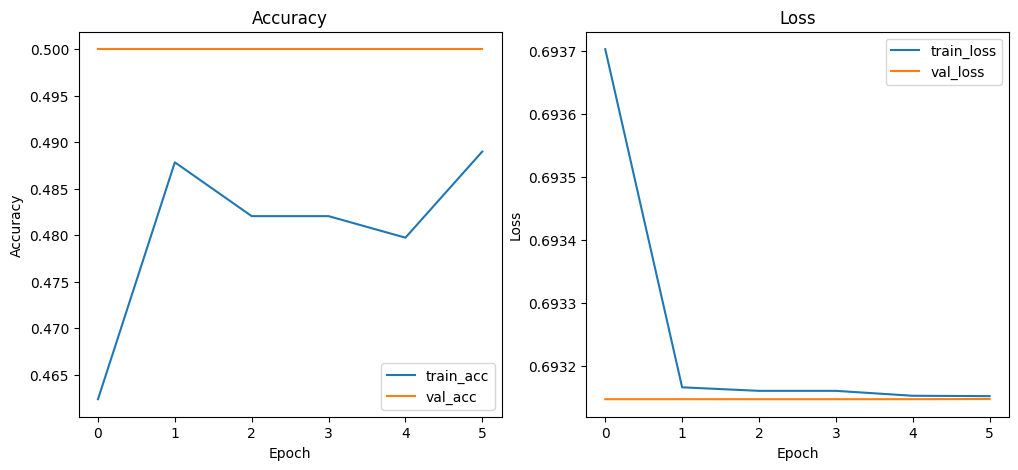

In [11]:
def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history)


### **Cell 11 — Confusion Matrix**

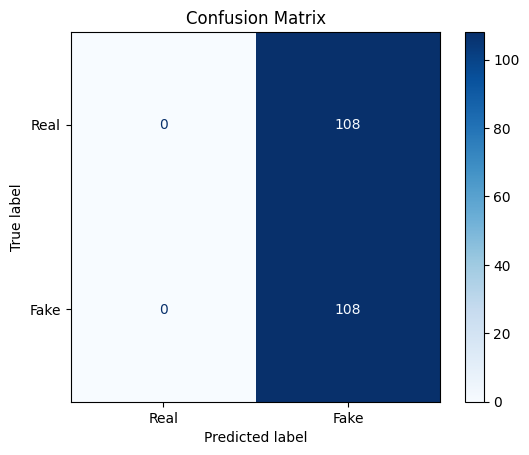

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### **Cell 12 — ROC Curve**

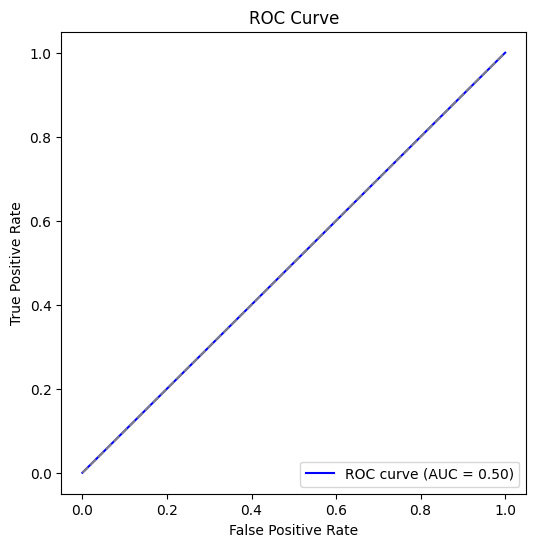

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
